# WEEK 1

## Histogram Definitions and Data Extraction

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
import cv2
from tqdm import tqdm
from itertools import product


from histograms import *
from similarity_measures_optimized import *
from mapk import *

### Calculate all the historgrams for the images in train and query sets

In [2]:
# Paths
train_directory = "../BBDD/"
query_directory = "../qsd1_w1/"

# Get image file lists
train_images = [f for f in os.listdir(train_directory) if f.endswith('.jpg')]
query_images = [f for f in os.listdir(query_directory) if f.endswith('.jpg')]

# Lists for all histograms
train_rgb_mean_histograms = []
train_rgb_concat_histograms = []
train_hsv_concat_histograms = []
train_lab_concat_histograms = []
train_ycbcr_concat_histograms = []
train_xyz_concat_histograms = []
train_hls_concat_histograms = []
train_yuv_concat_histograms = []
train_gray_histograms = []

query_rgb_mean_histograms = []
query_rgb_concat_histograms = []
query_hsv_concat_histograms = []
query_lab_concat_histograms = []
query_ycbcr_concat_histograms = []
query_xyz_concat_histograms = []
query_hls_concat_histograms = []
query_yuv_concat_histograms = []
query_gray_histograms = []

def pil_to_cv2(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# ---------- Train set ----------
for img_name in tqdm(train_images, desc="Processing train images"):
    img_pil = Image.open(os.path.join(train_directory, img_name))
    img_cv = pil_to_cv2(img_pil)
    height, width = img_cv.shape[:2]

    # RGB Mean Histogram
    rgb_mean_hist = RGB_Mean_Histogram(height, width)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    for i, color in enumerate(["red", "green", "blue"]):
        channel = img_rgb[:,:,i].flatten()
        hist = np.bincount(channel, minlength=256)
        rgb_mean_hist.setHist(color, hist)
    rgb_mean_hist.calculate_1D_hist()
    rgb_mean_hist.normalize()
    train_rgb_mean_histograms.append(copy.copy(rgb_mean_hist))

    # RGB Concat Histogram
    rgb_concat_hist = RGB_Concat_Histogram(height, width)
    for i, color in enumerate(["red", "green", "blue"]):
        channel = img_rgb[:,:,i].flatten()
        hist = np.bincount(channel, minlength=256)
        rgb_concat_hist.setHist(color, hist)
    rgb_concat_hist.calculate_concat_hist()
    rgb_concat_hist.normalize()
    train_rgb_concat_histograms.append(copy.copy(rgb_concat_hist))

    # HSV Concat Histogram
    hsv_concat_hist = HSV_Concat_Histogram(height, width)
    img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
    h_hist = np.bincount(img_hsv[:,:,0].flatten(), minlength=256)
    s_hist = np.bincount(img_hsv[:,:,1].flatten(), minlength=256)
    v_hist = np.bincount(img_hsv[:,:,2].flatten(), minlength=256)
    hsv_concat_hist.setHist(h_hist, s_hist, v_hist)
    hsv_concat_hist.calculate_concat_hist()
    hsv_concat_hist.normalize()
    train_hsv_concat_histograms.append(copy.copy(hsv_concat_hist))

    # CIELAB Concat Histogram
    lab_concat_hist = CIELAB_Concat_Histogram(height, width)
    img_lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    l_hist = np.bincount(img_lab[:,:,0].flatten(), minlength=256)
    a_hist = np.bincount(img_lab[:,:,1].flatten(), minlength=256)
    b_hist = np.bincount(img_lab[:,:,2].flatten(), minlength=256)
    lab_concat_hist.setHist(l_hist, a_hist, b_hist)
    lab_concat_hist.calculate_concat_hist()
    lab_concat_hist.normalize()
    train_lab_concat_histograms.append(copy.copy(lab_concat_hist))

    # YCbCr Concat Histogram
    ycbcr_concat_hist = YCbCr_Concat_Histogram(height, width)
    img_ycbcr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YCrCb)
    y_hist = np.bincount(img_ycbcr[:,:,0].flatten(), minlength=256)
    cb_hist = np.bincount(img_ycbcr[:,:,1].flatten(), minlength=256)
    cr_hist = np.bincount(img_ycbcr[:,:,2].flatten(), minlength=256)
    ycbcr_concat_hist.setHist(y_hist, cb_hist, cr_hist)
    ycbcr_concat_hist.calculate_concat_hist()
    ycbcr_concat_hist.normalize()
    train_ycbcr_concat_histograms.append(copy.copy(ycbcr_concat_hist))
    
    # XYZ Concat Histogram
    xyz_concat_hist = XYZ_Concat_Histogram(height, width)
    img_xyz = cv2.cvtColor(img_cv, cv2.COLOR_BGR2XYZ)
    x_hist = np.bincount(img_xyz[:,:,0].flatten(), minlength=256)
    y_hist = np.bincount(img_xyz[:,:,1].flatten(), minlength=256)
    z_hist = np.bincount(img_xyz[:,:,2].flatten(), minlength=256)
    xyz_concat_hist.setHist(x_hist, y_hist, z_hist)
    xyz_concat_hist.calculate_concat_hist()
    xyz_concat_hist.normalize()
    train_xyz_concat_histograms.append(copy.copy(xyz_concat_hist))
    
    # HLS Concat Histogram
    hls_concat_hist = HLS_Concat_Histogram(height, width)
    img_hls = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HLS)
    h_hist = np.bincount(img_hls[:,:,0].flatten(), minlength=256)
    l_hist = np.bincount(img_hls[:,:,1].flatten(), minlength=256)
    s_hist = np.bincount(img_hls[:,:,2].flatten(), minlength=256)
    hls_concat_hist.setHist(h_hist, l_hist, s_hist)
    hls_concat_hist.calculate_concat_hist()
    hls_concat_hist.normalize()
    train_hls_concat_histograms.append(copy.copy(hls_concat_hist))
    
    # YUV Concat Histogram
    yuv_concat_hist = YUV_Concat_Histogram(height, width)
    img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
    y_hist = np.bincount(img_yuv[:,:,0].flatten(), minlength=256)
    u_hist = np.bincount(img_yuv[:,:,1].flatten(), minlength=256)
    v_hist = np.bincount(img_yuv[:,:,2].flatten(), minlength=256)
    yuv_concat_hist.setHist(y_hist, u_hist, v_hist)
    yuv_concat_hist.calculate_concat_hist()
    yuv_concat_hist.normalize()
    train_yuv_concat_histograms.append(copy.copy(yuv_concat_hist))

    # Gray Histogram
    gray_hist = Gray_Histogram(width, height)
    img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    gray_hist.setHist(np.bincount(img_gray.flatten(), minlength=256))
    gray_hist.normalize()
    train_gray_histograms.append(copy.copy(gray_hist))

# ---------- Query set ----------
for img_name in tqdm(query_images, desc="Processing query images"):
    img_pil = Image.open(os.path.join(query_directory, img_name))
    img_cv = pil_to_cv2(img_pil)
    height, width = img_cv.shape[:2]

    # RGB Mean Histogram
    rgb_mean_hist = RGB_Mean_Histogram(height, width)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    for i, color in enumerate(["red", "green", "blue"]):
        channel = img_rgb[:,:,i].flatten()
        hist = np.bincount(channel, minlength=256)
        rgb_mean_hist.setHist(color, hist)
    rgb_mean_hist.calculate_1D_hist()
    rgb_mean_hist.normalize()
    query_rgb_mean_histograms.append(copy.copy(rgb_mean_hist))

    # RGB Concat Histogram
    rgb_concat_hist = RGB_Concat_Histogram(height, width)
    for i, color in enumerate(["red", "green", "blue"]):
        channel = img_rgb[:,:,i].flatten()
        hist = np.bincount(channel, minlength=256)
        rgb_concat_hist.setHist(color, hist)
    rgb_concat_hist.calculate_concat_hist()
    rgb_concat_hist.normalize()
    query_rgb_concat_histograms.append(copy.copy(rgb_concat_hist))

    # HSV Concat Histogram
    hsv_concat_hist = HSV_Concat_Histogram(height, width)
    img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
    h_hist = np.bincount(img_hsv[:,:,0].flatten(), minlength=256)
    s_hist = np.bincount(img_hsv[:,:,1].flatten(), minlength=256)
    v_hist = np.bincount(img_hsv[:,:,2].flatten(), minlength=256)
    hsv_concat_hist.setHist(h_hist, s_hist, v_hist)
    hsv_concat_hist.calculate_concat_hist()
    hsv_concat_hist.normalize()
    query_hsv_concat_histograms.append(copy.copy(hsv_concat_hist))

    # CIELAB Concat Histogram
    lab_concat_hist = CIELAB_Concat_Histogram(height, width)
    img_lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    l_hist = np.bincount(img_lab[:,:,0].flatten(), minlength=256)
    a_hist = np.bincount(img_lab[:,:,1].flatten(), minlength=256)
    b_hist = np.bincount(img_lab[:,:,2].flatten(), minlength=256)
    lab_concat_hist.setHist(l_hist, a_hist, b_hist)
    lab_concat_hist.calculate_concat_hist()
    lab_concat_hist.normalize()
    query_lab_concat_histograms.append(copy.copy(lab_concat_hist))

    # YCbCr Concat Histogram
    ycbcr_concat_hist = YCbCr_Concat_Histogram(height, width)
    img_ycbcr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YCrCb)
    y_hist = np.bincount(img_ycbcr[:,:,0].flatten(), minlength=256)
    cb_hist = np.bincount(img_ycbcr[:,:,1].flatten(), minlength=256)
    cr_hist = np.bincount(img_ycbcr[:,:,2].flatten(), minlength=256)
    ycbcr_concat_hist.setHist(y_hist, cb_hist, cr_hist)
    ycbcr_concat_hist.calculate_concat_hist()
    ycbcr_concat_hist.normalize()
    query_ycbcr_concat_histograms.append(copy.copy(ycbcr_concat_hist))
    
    # XYZ Concat Histogram
    xyz_concat_hist = XYZ_Concat_Histogram(height, width)
    img_xyz = cv2.cvtColor(img_cv, cv2.COLOR_BGR2XYZ)
    x_hist = np.bincount(img_xyz[:,:,0].flatten(), minlength=256)
    y_hist = np.bincount(img_xyz[:,:,1].flatten(), minlength=256)
    z_hist = np.bincount(img_xyz[:,:,2].flatten(), minlength=256)
    xyz_concat_hist.setHist(x_hist, y_hist, z_hist)
    xyz_concat_hist.calculate_concat_hist()
    xyz_concat_hist.normalize()
    query_xyz_concat_histograms.append(copy.copy(xyz_concat_hist))
    
    # HLS Concat Histogram
    hls_concat_hist = HLS_Concat_Histogram(height, width)
    img_hls = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HLS)
    h_hist = np.bincount(img_hls[:,:,0].flatten(), minlength=256)
    l_hist = np.bincount(img_hls[:,:,1].flatten(), minlength=256)
    s_hist = np.bincount(img_hls[:,:,2].flatten(), minlength=256)
    hls_concat_hist.setHist(h_hist, l_hist, s_hist)
    hls_concat_hist.calculate_concat_hist()
    hls_concat_hist.normalize()
    query_hls_concat_histograms.append(copy.copy(hls_concat_hist))
    
    # YUV Concat Histogram
    yuv_concat_hist = YUV_Concat_Histogram(height, width)
    img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
    y_hist = np.bincount(img_yuv[:,:,0].flatten(), minlength=256)
    u_hist = np.bincount(img_yuv[:,:,1].flatten(), minlength=256)
    v_hist = np.bincount(img_yuv[:,:,2].flatten(), minlength=256)
    yuv_concat_hist.setHist(y_hist, u_hist, v_hist)
    yuv_concat_hist.calculate_concat_hist()
    yuv_concat_hist.normalize()
    query_yuv_concat_histograms.append(copy.copy(yuv_concat_hist))

    # Gray Histogram
    gray_hist = Gray_Histogram(width, height)
    img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    gray_hist.setHist(np.bincount(img_gray.flatten(), minlength=256))
    gray_hist.normalize()
    query_gray_histograms.append(copy.copy(gray_hist))

Processing query images: 100%|██████████| 30/30 [00:02<00:00, 11.13it/s]


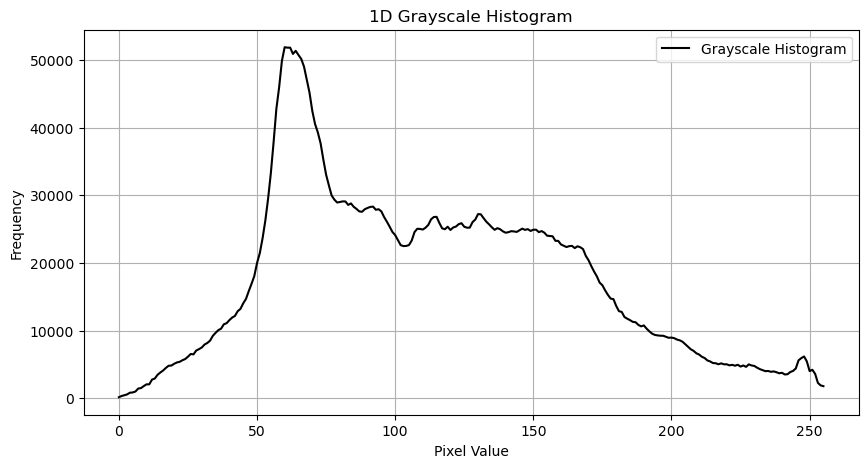

In [3]:
# Show example histograms for query image 3
#train_rgb_mean_histograms[2].show()
#train_rgb_concat_histograms[2].show()
#train_hsv_concat_histograms[2].show()
#train_lab_concat_histograms[2].show()
#train_ycbcr_concat_histograms[2].show()
train_gray_histograms[3].show()

## Parameter Search

We try the following approaches:
- For each descriptor use one individual similarity measure
- For each descriptor find a ponderation of similarity measures (use all sim mesures)
- Find a ponderation between descriptors and similarity measures (use all descriptors and sim measures)
- Parameter search using less bins for histograms

In [4]:
with open("../qsd1_w1/gt_corresps.pkl", "rb") as f:
    gt_data = pickle.load(f)

def extract_histograms(hist_objects, attr="normalized"):
    return [np.array(getattr(h, attr)) for h in hist_objects]

train_rgb_mean_hists = extract_histograms(train_rgb_mean_histograms)
query_rgb_mean_hists = extract_histograms(query_rgb_mean_histograms)
train_rgb_concat_hists = extract_histograms(train_rgb_concat_histograms)
query_rgb_concat_hists = extract_histograms(query_rgb_concat_histograms)
train_hsv_concat_hists = extract_histograms(train_hsv_concat_histograms)
query_hsv_concat_hists = extract_histograms(query_hsv_concat_histograms)
train_lab_concat_hists = extract_histograms(train_lab_concat_histograms)
query_lab_concat_hists = extract_histograms(query_lab_concat_histograms)
train_ycbcr_concat_hists = extract_histograms(train_ycbcr_concat_histograms)
query_ycbcr_concat_hists = extract_histograms(query_ycbcr_concat_histograms)
train_xyz_concat_hists = extract_histograms(train_xyz_concat_histograms)
query_xyz_concat_hists = extract_histograms(query_xyz_concat_histograms)
train_hls_concat_hists = extract_histograms(train_hls_concat_histograms)
query_hls_concat_hists = extract_histograms(query_hls_concat_histograms)
train_yuv_concat_hists = extract_histograms(train_yuv_concat_histograms)
query_yuv_concat_hists = extract_histograms(query_yuv_concat_histograms)
train_gray_hists = extract_histograms(train_gray_histograms)
query_gray_hists = extract_histograms(query_gray_histograms)

similarity_matrix_funcs = [
    euclidean_distance_matrix,
    l1_distance_matrix,
    x2_distance_matrix,
    histogram_intersection_matrix,
    hellinger_kernel_matrix,
    cosine_similarity_matrix,
    bhattacharyya_distance_matrix,
    correlation_matrix,
    kl_divergence_matrix
    # emd_matrix
]

similarity_names = ["Euclidean", "L1", "Chi^2", "Hist. Intersection", "Hellinger", "Cosine", "Bhattacharyya", "Correlation", "KL Divergence"]#, "EMD"]
descriptor_names = [
    "RGB Mean Histogram",
    "RGB Concat Histogram",
    "HSV Concat Histogram",
    "CIELAB Concat Histogram",
    "YCbCr Concat Histogram",
    "XYZ Concat Histogram",
    "HLS Concat Histogram",
    "YUV Concat Histogram",
    "Gray Histogram"
]
descriptor_pairs = [
    (query_rgb_mean_hists, train_rgb_mean_hists),
    (query_rgb_concat_hists, train_rgb_concat_hists),
    (query_hsv_concat_hists, train_hsv_concat_hists),
    (query_lab_concat_hists, train_lab_concat_hists),
    (query_ycbcr_concat_hists, train_ycbcr_concat_hists),
    (query_xyz_concat_hists, train_xyz_concat_hists),
    (query_hls_concat_hists, train_hls_concat_hists),
    (query_yuv_concat_hists, train_yuv_concat_hists),
    (query_gray_hists, train_gray_hists)
]

In [5]:
# sim_scores[d_idx][q_idx][t_idx][f_idx]: descriptor, query, train, similarity
sim_scores = []
for d_idx, (query_hists, train_hists) in enumerate(descriptor_pairs):
    desc_scores = np.zeros((len(query_hists), len(train_hists), len(similarity_matrix_funcs)))
    Q = np.array([normalize_hist(h) for h in query_hists])
    M = np.array([normalize_hist(h) for h in train_hists])
    for f_idx, func in enumerate(similarity_matrix_funcs):
        D = func(Q, M)
        # If similarity (intersection/hellinger), invert sign for sorting later
        if func.__name__ in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
            D = -D
        desc_scores[:, :, f_idx] = D
    sim_scores.append(desc_scores)

In [6]:
# Experiment 1: Compare descriptors and similarity measures
results_matrix = np.zeros((len(descriptor_names), len(similarity_matrix_funcs)))
TOP_K = 5

for d_idx in range(len(descriptor_names)):
    desc_scores = sim_scores[d_idx]  # scores for a specific descriptor
    for f_idx in range(len(similarity_matrix_funcs)):
        # For each query image, retrieve the indices of the TOP_K most similar train images
        predicted = []
        for q_idx in range(desc_scores.shape[0]):
            scores = desc_scores[q_idx, :, f_idx]
            top_indices = np.argsort(scores)[:TOP_K]
            predicted.append(list(top_indices))

        score = mapk(gt_data, predicted, k=TOP_K)
        results_matrix[d_idx, f_idx] = score

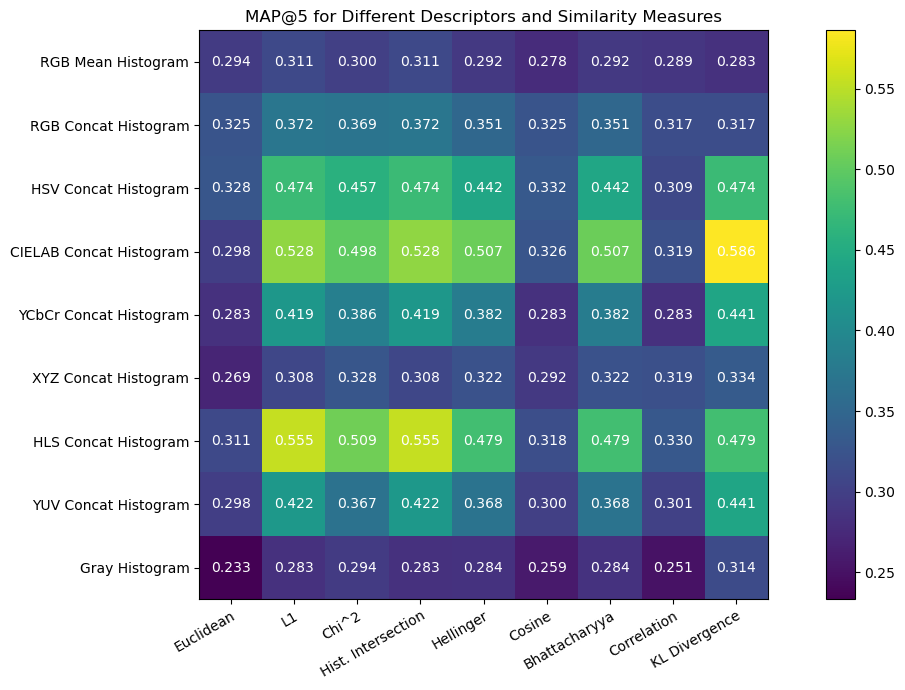

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(results_matrix, cmap="viridis")

# Show all ticks and label them
ax.set_xticks(np.arange(len(similarity_names)))
ax.set_yticks(np.arange(len(descriptor_names)))
ax.set_xticklabels(similarity_names)
ax.set_yticklabels(descriptor_names)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Loop over data to create text annotations
for i in range(len(descriptor_names)):
    for j in range(len(similarity_names)):
        text = ax.text(j, i, f"{results_matrix[i, j]:.3f}",
                       ha="center", va="center", color="w")

ax.set_title("MAP@5 for Different Descriptors and Similarity Measures")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [8]:
# # Experiment 2: Weighted similarity measures for each descriptor
# TOP_K = 5
# weight_steps = [x*0.25 for x in range(0,5)]

# best_desc = None
# best_score = -np.inf
# best_weights = None

# for d_idx, desc_name in tqdm(enumerate(descriptor_names), desc="Weights search for descriptors", total=len(descriptor_names)):
#     desc_scores = sim_scores[d_idx]
#     n_weights = len(similarity_matrix_funcs)
#     for weights in tqdm(product(weight_steps, repeat=n_weights)):
#         weights = np.array(weights)
#         if np.any(weights): # Avoid all-zero weights
#             weighted = np.dot(desc_scores, weights)
#             predicted = [list(np.argsort(weighted[q_idx])[:TOP_K]) for q_idx in range(weighted.shape[0])]
#             score = mapk(gt_data, predicted, k=TOP_K)
#             if score > best_score:
#                 best_desc = desc_name
#                 best_score = score
#                 best_weights = weights.copy()
                
# print(f"Best Descriptor: {best_desc}")
# print(f"Best MAP@{TOP_K}: {best_score:.3f} with weights {best_weights}")

In [ ]:
# Experiment 3: Combine two descriptors and all similarity scores by weights 
# Only try combination of the best P descriptors and M measures from the experiment 1 to make it computationally viable
from itertools import product, combinations
from tqdm import tqdm
TOP_K = 5
weight_steps = [0,0.5,1]
P_descriptors = 4 # Number of descriptors to combine
M_measures = 4    # Number of similarity measures to combine

# Build a ranking of (descriptor, measure) using Experiment 1 results_matrix
# Fallback: if results_matrix not available, default to full lists
try:
    desc_rank = np.argsort(-results_matrix.mean(axis=1))[:P_descriptors]
    # find best M_measures per selected descriptor and take the union
    sim_scores_by_measure = results_matrix[:, :]
    sim_rank = np.argsort(-sim_scores_by_measure.mean(axis=0))[:M_measures]
except Exception:
    desc_rank = np.arange(min(P_descriptors, len(descriptor_names)))
    sim_rank = np.arange(min(M_measures, len(similarity_matrix_funcs)))

# names of the p best descriptors (map desc_rank to names)
descriptor_pairs_idx = list(combinations(desc_rank, 2))

best_combo = None
best_score = -np.inf
best_weights = None


for d1_idx, d2_idx in tqdm(descriptor_pairs_idx, desc='Descriptor pairs'):
    desc1_scores = sim_scores[d1_idx][:, :, sim_rank]  # (nq, nm, M_measures)
    desc2_scores = sim_scores[d2_idx][:, :, sim_rank]
    combined_scores = np.concatenate([desc1_scores, desc2_scores], axis=2)  # (nq, nm, 2*M_measures)
    n_combined = combined_scores.shape[2]
    for weights in product(weight_steps, repeat=n_combined):
        weights = np.array(weights)
        if np.any(weights):
            weighted = np.dot(combined_scores, weights)
            predicted = [list(np.argsort(weighted[q_idx])[:TOP_K]) for q_idx in range(weighted.shape[0])]
            score = mapk(gt_data, predicted, k=TOP_K)
            if score > best_score:
                best_combo = (descriptor_names[d1_idx], descriptor_names[d2_idx])
                best_score = score
                best_weights = weights.copy()
                
print(f"Best Descriptor Pair: {best_combo}")
print(f"Best MAP@{TOP_K}: {best_score:.3f} with weights {best_weights}")

Descriptor pairs: 100%|██████████| 6/6 [00:23<00:00,  3.95s/it]

Best Descriptor Pair: ('CIELAB Concat Histogram', 'HLS Concat Histogram')
Best MAP@5: 0.622 with weights [0.  0.  0.5 0.  1.  0.5 0.  0. ]
